# Practical 8

## Introduction to Data Mining 

## Ensemble Learning

"Ensembles" are an approach for making predictions that involves combining several models together. 

The concept is illustrated below with a logistic regression model, a decision tree and a k nearest neighbours model. Instead of making a prediction with one of the models, predictions are made by taking input from all of the models. Specifically, given some features X, a combined prediction y  is found by first obtaining predictions from each of the models and combining it by some method: for example voting (taking the majority of class predictions) or taking the average (also applicable in regression). 

![title](images/ensembles.png)

The approach has significant benefits and many of the most effective algorithms in data mining are based on ensembles (for example Random Forests, Ada Boost). Benefits of ensembles includes that predictions from several models combined on average has a lower error than any of the individual models separately, the combined model also generally has less tendency for overfitting. 

This can be understood to be because the variance (i.e. of the predictions) is reduced and if the models used in constructing the combined model are independent (that is they are have different data and/or different modelling processes used in determining them) then the resulting model will have less "bias" than any of the indivudal models (e.g. linear models have a particular bias to finding linear patterns and combining linear and non linear models prevents this bias).

### Combining models obtained from different data subsets

Bagging, boosting and stacking are three variants or approaches for constructing multiple models that can be used together. Often many models that are not so good by themselves can be combined together into a good model. Bagging, boosting and stacking can be thought of as "Meta" algorithms (meaning algorithms that have as input or operate on several sub-algorithms or processes that act on the data).

#### Bagging
Creating several models (which are then combined) by generating additional training data through random resampling from the original data set and then using different subsets of this data to different train models. See also http://scikit-learn.org/stable/modules/ensemble.html#bagging

#### Boosting
Boosting is a more complex sequential approach (selection of models and data depends on the previous step). It extends the training data selection idea used in bagging by selectively choosing data to train the models in the ensemble in order to create models to better classify training examples that are misclassified by other models already in the ensemble. 

In boosting an initial set of models is generated from subsets of the training data, then additional models are trained by selecting training data that consists of examples that were most likely to be misclassified by the original models obtained in the first step. See also http://scikit-learn.org/stable/modules/ensemble.html

#### Stacking
In stacking it is generally understood that several model learning algorithms are used rather than just varying the data. In addition, instead of using simple mathematical function such as the mean, or majority or weighted voting to combine predictions, a data mining model (such as logistic regression) can be used to combine the outputs/predictions of many indivudal models together.


## 1. Iris Example

Lets look at an example of classifying with several models on the Iris data set in which we explicitly create our models with different algorithms and then combine them. We use only 2 feature columns which makes the problem more difficult. You will learn the Naive Bayes algorithm in the next Lecture. Random Forests are in themselves ensemble classifiers.


#### Generate invidual models

In [25]:
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target

In [26]:
from sklearn import model_selection 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import numpy as np

Generate some models with cross validation and look at the accuracy. Try to run the cell several times to observe the different scores - generally around 90 - 95 percent. Also see confidence intervals.

In [27]:

clf1 = LogisticRegression()
clf2 = RandomForestClassifier()
clf3 = GaussianNB()

print('5-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3], ['Logistic Regression', 'Random Forest', 'naive Bayes']):
    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.92 (+/- 0.06) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]


#### Construct ensemble

Implement ensemble classifier with voting. 

Two approaches to voting are majority voting in which the ensemble prediction is majority class predicted by the component models and weighted voting in which probability/confidence levels are used to adjust the vote (may be based on class probabilities produced by the algorithm and/or derived from an estimate of the model performance). 

For example if we had predictions clf1 => Versicolor, clf2 => Versicolor, clf3  => Setosa by majority voting the ensemble would predict Versicolor. 

We use an approach of weighted average probabilities that combines a weight for the model and the class probabilities to produce a value between 0 and 1 that is the combined prediction for each class weighted by the models weight, ie for each possible class calculate: weight_model1 \* probability_model1 + weight_model2 \* probability_model2 + ... 

We take the highest value. For example if the probabilities of class membership from the three models are as follows:
- clf1: Setosa 0.2, Versicolor 0.5, Virginica 0.3
- clf2: Setosa 0.6, Versicolor 0.3, Virginica 0.1
- clf3: Setosa 0.3, Versicolor 0.4, Virginica 0.3

The highest score is for versicolor as (1\*0.5 + 1\*0.3 + 1\*0.4)/3 = 0.4

Note: the scores for Setosa and Verginica were:
- Setosa (1\*0.2 + 1\*0.6 + 1\*0.3)/3 = 0.37
- Virginica (1\*0.3 + 1\*0.1 + 1\*0.3)/3 = 0.23

In the following implementation we use the concept of classes in Python (see https://docs.python.org/3/tutorial/classes.html)


In [28]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
import numpy as np
import operator

class EnsembleClassifier(BaseEstimator, ClassifierMixin):

    """
    Paramters for constructor
    clfs: iterable list of scikit-learn classifier objects
    weights: list of weights for the clf (float or int is acceptable)
    """
    def __init__(self, clfs, weights=None):
        self.clfs = clfs
        self.weights = weights    

    
    """
    Fit some data to each of the models in the ensemble    
    X : numpy array          
    y : list or numpy array 
    """
    def fit(self, X, y):
        for clf in self.clfs:
            clf.fit(X, y)

    """
    Generate predictions with majority voting   
    X : numpy array  
    Returns : numpy array containing predicted class labels by ensemble 
    
    """
    def predict(self, X):            
        self.classes_ = np.asarray([clf.predict(X) for clf in self.clfs])
        if self.weights:
            avg = self.predict_proba(X)
            # keep majority vote 
            maj = np.apply_along_axis(lambda x: max(enumerate(x), key=operator.itemgetter(1))[0], axis=1, arr=avg)
        else:
            maj = np.asarray([np.argmax(np.bincount(self.classes_[:,c])) for c in range(self.classes_.shape[1])])
        
        return maj

    """
    Generate predictions with probability majority voting   
    X : numpy array  
    Returns : numpy array containing  Weighted average probability for each class per sample 
    
    """ 
    def predict_proba(self, X):
        self.probas_ = [clf.predict_proba(X) for clf in self.clfs]
        avg = np.average(self.probas_, axis=0, weights=self.weights)

        return avg        
            

Apply the weighted voting schema we just implemented and test it.

In [29]:
# set equal weights for each of the component classifiers
eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[1,1,1])

# perform the test as before
for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
    scores = model_selection.cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.90 (+/- 0.05) [Logistic Regression]
Accuracy: 0.91 (+/- 0.03) [Random Forest]
Accuracy: 0.91 (+/- 0.04) [naive Bayes]
Accuracy: 0.95 (+/- 0.03) [Ensemble]


Run the above cell several times. Which of the classifiers performs the best each time?

Of course Ensemble performs best

#### Setting the weights

We can set the weights (and other paramters) by iterating through all possibilities if the size of the problem is not too large...

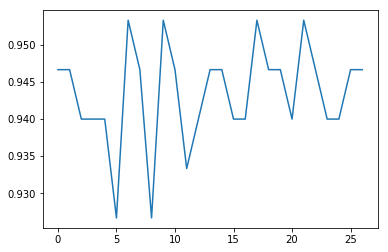

,w1,w2,w3,mean,std
0,1.0,1.0,1.0,0.946667,0.049889
1,1.0,1.0,2.0,0.946667,0.045216
2,1.0,1.0,3.0,0.940000,0.044222
3,1.0,2.0,1.0,0.940000,0.032660
4,1.0,2.0,2.0,0.940000,0.038873
5,1.0,2.0,3.0,0.926667,0.044222
6,1.0,3.0,1.0,0.953333,0.040000
7,1.0,3.0,2.0,0.946667,0.033993
8,1.0,3.0,3.0,0.926667,0.044222
9,2.0,1.0,1.0,0.953333,0.040000


In [16]:
import pandas as pd
np.random.seed(123)
df = pd.DataFrame(columns=('w1', 'w2', 'w3', 'mean', 'std'))

i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range(1,4):
            eclf = EnsembleClassifier(clfs=[clf1, clf2, clf3], weights=[w1,w2,w3])
            scores = model_selection.cross_val_score(
                                            estimator=eclf,
                                            X=X,
                                            y=y,
                                            cv=5,
                                            scoring='accuracy',
                                            n_jobs=1)

            df.loc[i] = [w1, w2, w3, scores.mean(), scores.std()]
            i += 1
            

import matplotlib.pyplot as plt
plt.plot(df['mean'])

plt.show() 
df

Is the setting for weights important?

To answer this question properly, adjust the above code to sort show confidence levels in the plot and sort the output list by the performance metric (mean and standard deviation). 

Hint: the confidence interval formula at 95% confidence level is  u +/- 1.96 * sd / sqrt(N).

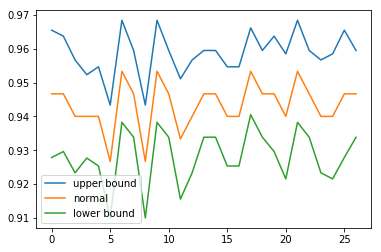

In [17]:
import matplotlib.pyplot as plt
plt.plot(df['mean'] +1.96 * df['std']/ np.sqrt(27), label = 'upper bound')
plt.plot(df['mean'], label = 'normal')
plt.plot(df['mean'] -1.96 * df['std']/ np.sqrt(27), label = 'lower bound')
plt.legend()
plt.show() 


## 2. Implementation

Review the Titanic problem from Practical 4 (see https://github.com/dr-adam/CS206/blob/master/practical4/practical%204.ipynb).

Do the following:
- Implement an ensemble classifier that uses both logistic regression and decision trees and another 3 algorithms of your choosing.
- Tune the weights of that the algorithms in your ensemble contribute to the ensemble classification based on the individual classifier performance.

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [39]:
data = pd.read_csv("titanic.csv")
x = data.drop(['Survived'], axis = 1)
y = data['Survived']
y.head()

clf1 = LogisticRegression()
clf2 = GaussianNB()
clf3 = DecisionTreeClassifier(criterion = "entropy" )
for clf, label in zip([clf1, clf2, clf3],['logistic','GaussianNB','tree']):
    scores = model_selection.cross_val_score(clf, x, y, cv = 5, scoring = 'accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.78 (+/- 0.07) [logistic]
Accuracy: 0.74 (+/- 0.08) [GaussianNB]
Accuracy: 0.75 (+/- 0.07) [tree]


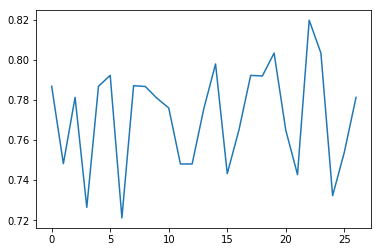

,w1,w2,w3,mean,std
0,1.0,1.0,1.0,0.786787,0.098085
1,1.0,1.0,2.0,0.748198,0.069563
2,1.0,1.0,3.0,0.781231,0.081905
3,1.0,2.0,1.0,0.726426,0.080492
4,1.0,2.0,2.0,0.786787,0.091934
5,1.0,2.0,3.0,0.792192,0.077042
6,1.0,3.0,1.0,0.721171,0.086006
7,1.0,3.0,2.0,0.787087,0.076468
8,1.0,3.0,3.0,0.786637,0.075393
9,2.0,1.0,1.0,0.780781,0.075800


In [44]:
import pandas as pd
df = pd.DataFrame(columns = ('w1', 'w2', 'w3', 'mean', 'std'))
i = 0
for w1 in range(1,4):
    for w2 in range(1,4):
        for w3 in range (1,4):
            eclf = EnsembleClassifier(clfs = [clf1, clf2, clf3], weights = [w1, w2, w3])
            scores = model_selection.cross_val_score(eclf, x, y, cv = 5, scoring = 'accuracy', n_jobs=1)
            df.loc[i] = [w1, w2, w3, scores.mean(), scores.std()]
            i+=1
import matplotlib.pyplot as plt
plt.plot(df['mean'])
plt.show()
df

## 3. AdaBoost

AdaBoost is a highly succesful algorithm which has shown good performance on many problems in the literature. Spend some time to read about it here: http://scikit-learn.org/stable/modules/ensemble.html#adaboost and also read some papers describing it here (this can probably safely be read in detail outside the class before or after - just try to skim through and find the key ideas to answer the question below): 
- https://cseweb.ucsd.edu/~yfreund/papers/boostingexperiments.pdf (original description)
- https://www.intlpress.com/site/pub/files/_fulltext/journals/sii/2009/0002/0003/SII-2009-0002-0003-a008.pdf (multiclass)

Write a 1-2 paragraph description of the the way that AdaBoost works and how it incorporates the ideas we just looked at (ensembles, selecting data, bagging and boosting etc).

Answer: The core principle of AdaBoost is to fit a sequence of weak learners on repeatedly modified versions of the data. On the first iteration, the model will low the weight of the right cases and increase the weight of the wrong cases at the same time. So, in the later iteration, the wrong cases will be paid more concentration. The extreamly hard cases will get the highest weight which will force all the learners to concentrate on it more. Thus, the error rate decrease.

In this question we are using the Nursery Data Set which is located in the UCI Machine learning repository (download from here: https://archive.ics.uci.edu/ml/datasets/nursery)

Implement AdaBoost to learn models to learn prediction models for the Nursery Data Set (predict the last column which has values: not_recom, recommend, very_recom, priority, spec_prior).

Compare your results to those described for the algorithm and data set in this paper: https://ti.arc.nasa.gov/m/profile/oza/files/ozru01a.pdf

Note: this question requires you to do quite a lot: 
- download the data, 
- read and understand the description of the data in the UCI repository description, 
- then implement the model, 
- and finally set up your experiment to use test and training data of different sizes corresponding to the paper Online Bagging and Boosting by Nikunj Oza and Stuart Russel (see section 4 of the above paper with experimental results)
- this will enable you to compare your result with the paper

In [89]:
data = pd.read_csv("nursery.csv")
x = data.drop(['class'], axis = 1)
y = data['class']

data.head()

,parents,has_nurs,form,children,housing,finance,social,health,class
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction import DictVectorizer

D = data.to_dict()
v = DictVectorizer(sparse = False)
X = v.fit_transform(D['children'])
print (v.get_feature_names())
print(X)



# clf = AdaBoostClassifier(n_estimators = 100)
# scores = cross_val_score(clf,x,y)
# scores.mean()
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

['0=1', '10000=2', '10001=2', '10002=2', '10003=2', '10004=2', '10005=2', '10006=2', '10007=2', '10008=2', '10009=2', '1000=3', '10010=2', '10011=2', '10012=2', '10013=2', '10014=2', '10015=2', '10016=2', '10017=2', '10018=2', '10019=2', '1001=3', '10020=2', '10021=2', '10022=2', '10023=2', '10024=2', '10025=2', '10026=2', '10027=2', '10028=2', '10029=2', '1002=3', '10030=2', '10031=2', '10032=2', '10033=2', '10034=2', '10035=2', '10036=2', '10037=2', '10038=2', '10039=2', '1003=3', '10040=2', '10041=2', '10042=2', '10043=2', '10044=3', '10045=3', '10046=3', '10047=3', '10048=3', '10049=3', '1004=3', '10050=3', '10051=3', '10052=3', '10053=3', '10054=3', '10055=3', '10056=3', '10057=3', '10058=3', '10059=3', '1005=3', '10060=3', '10061=3', '10062=3', '10063=3', '10064=3', '10065=3', '10066=3', '10067=3', '10068=3', '10069=3', '1006=3', '10070=3', '10071=3', '10072=3', '10073=3', '10074=3', '10075=3', '10076=3', '10077=3', '10078=3', '10079=3', '1007=3', '10080=3', '10081=3', '10082=3',

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier
iris = load_iris()
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, iris.data, iris.target)
iris.target



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])